# 6. Gyakorlat: Aktor-Kritikus
## Könyvtárak

In [47]:
%pip install gym[box2d]
%pip install gym\[box2d\]
%pip install box2d-py

zsh:1: no matches found: gym[box2d]
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [48]:
import gym
import random 
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import base64, io
from collections import deque
from collections import namedtuple

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

mpl.rc('animation', html='jshtml')

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings('ignore')

## Vizualizációs függvények

In [49]:
# Jeleneti változó beállítása
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Szekvenciális képkockák lejátszása egymás után
def plot_animation(frames, repeat=True, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Egy epizód lejátszása egy neurális hálózattal
def render_policy_net(agent, n_max_steps=500, seed=42, done_close=True, epsilon=0):
    env = gym.make('LunarLander-v2')
    obs = env.reset()
    frames = []
    rewards = []
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        
        action, entropy = agent.act(obs)
        obs, reward, done, info = env.step(action) # Execute step
        rewards.append(reward)
        
        if(done_close and done):
            break

    env.close()
    return frames, rewards

# Jutalmak ábrázolása
def plot_rewards(rewards, episode=True):
    n = len(rewards)
    if(episode):
        df = pd.DataFrame({'Rewards': rewards, 'Step': np.arange(n)})
        sns.lineplot(data=df, x='Step', y='Rewards').set(title="Rewards across "+str(n)+" steps in episode:")
    else:
        df = pd.DataFrame({'Rewards': rewards, 'Epoch': np.arange(n)})
        sns.lineplot(data=df, x='Epoch', y='Rewards').set(title="Rewards across "+str(n)+" episodes")

---
## $Q$-hálózat

In [50]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size): # Define the architecture
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        
        # Kritikus fej: visszaatéríti a V(s) állapot értéket
        self.critic_head = nn.Linear(64, 1)

        # Aktor fej: visszatéríti a Q(s,a) cselekvés értéket
        self.actor_head = nn.Linear(64, action_size)
        
    def forward(self, state):  # Előrecsatolás a rétegeken
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)

        # Milyen jó a jelenlegi állapot?
        state_value = self.critic_head(x)

        # Cselekvések megtételének valószínűség eloszlása
        policy_dist = F.softmax(self.actor_head(x), dim=-1)

        return state_value, policy_dist

---
## Ügynök
The methods here are standard for a DQN Agent. 

In [51]:
class Agent():
    def __init__(self, state_size, action_size, alpha, gamma):
        # Paraméterek
        self.alpha = alpha
        self.gamma = gamma
        self.state_size = state_size
        self.action_size = action_size
        # Környezet és optimalizáló
        self.qnetwork = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr = alpha) 
        # Követési struktúrák
        self.Vs = []
        self.rewards = []
        self.log_probs = []
    
    def act(self, state):
        value, policy_dist = self.qnetwork.forward(state)
        value = value.detach().numpy()[0, 0]
        dist = policy_dist.detach().numpy() 
        action = np.random.choice(self.action_size, p = np.squeeze(dist))

        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(np.mean(dist) * np.log(dist))

        self.Vs.append(value)
        self.log_probs.append(log_prob)

        return action, entropy

    def learn(self, Q, entropy_term):
        # Q-értékek kiszámítása
        Qs = np.zeros_like(self.Vs)
        for t in reversed(range(len(self.rewards))):
            Q = self.rewards[t] + self.gamma * Q
            Qs[t] = Q
        
        # Aktor-kritikus frissítése
        V = torch.FloatTensor(self.Vs)
        Qs = torch.FloatTensor(Qs)
        log_probs = torch.stack(self.log_probs)

        advantage = Qs - V  # Előnyfüggvény kiszámítása
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()

        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        self.optimizer.zero_grad()  # Gradiensek 0-ra állítása
        ac_loss.backward()  # Gradiensek visszacsatolása a hálózatba
        self.optimizer.step()  # Lépés végrehajtása az optimalizálóval

    def forget(self):  # Változók visszaállítása az eredetibe
        self.Vs = []
        self.rewards = []
        self.log_probs = []


---
## Tanítás
First, variables

In [52]:
max_t = 1000  # Max. időlépés egy epizódon belül
gamma = 0.99  # Diszkont ráta
alpha = 5e-4  # Tanulási sebesség 
batch_size = 64  # Kötegméret
n_episodes = 12000  # Epizódok száma
update_every = 4  # Hány epizódonként frissüljön a hálózat
buffer_size = int(1e5)  # Tapasztalat visszajátszás mérete
entropy_term = 0

scores = []  # Jutalmak követése
scores_window = deque(maxlen=100)  # Utolsó 100 iteráció követése

env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

actor_critic = Agent(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma)

print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [53]:
for i_episode in range(n_episodes):
    actor_critic.forget()
    s = np.array(env.reset()[0])
    score = 0
    for steps in range(max_t):
        action, entropy = actor_critic.act(s)
        sp, reward, done, info, _ = env.step(action)
        sp = np.array(sp)
        actor_critic.rewards.append(reward)

        entropy_term += entropy
        s = sp
        score += reward

        if(done or steps == max_t-1):
            Q, _ = actor_critic.qnetwork.forward(sp)
            Q = Q.detach().numpy()[0,0]
            break
    
    actor_critic.learn(Q, entropy_term=entropy_term)
    scores_window.append(score) # Save most recent score
    scores.append(score) # Save most recent score

    if(i_episode % 200 == 0): # Every 100 episodes print out some data
        print('Episode: '+str(i_episode)+', Average score: '+str(np.mean(scores_window)))
        
    if(np.mean(scores_window) >= 250.0): # Consider the task solved if the reward is over 250
        print('Environment solved in: '+str(i_episode-100)+" episodes.")
        print('Average score: '+str(np.mean(scores_window)))
        torch.save(actor_critic.qnetwork.state_dict(), 'checkpoint.pth') # Save model
        break


Episode: 0, Average score: -254.99448269720642
Episode: 200, Average score: -169.46239294403313
Episode: 400, Average score: -151.44533367665926
Episode: 600, Average score: -149.23060436208553
Episode: 800, Average score: -133.07853972922732
Episode: 1000, Average score: -135.98612346413447
Episode: 1200, Average score: -122.59723150424679
Episode: 1400, Average score: -127.11440074241759
Episode: 1600, Average score: -95.15670237605765
Episode: 1800, Average score: -85.78106343545298
Episode: 2000, Average score: -46.2452830818365


KeyboardInterrupt: 

In [ ]:
np.array(env.reset()[0])

array([-0.00711899,  1.4166012 , -0.72108054,  0.2524753 ,  0.00825581,
        0.16333541,  0.        ,  0.        ], dtype=float32)

### Let's plot the rewards

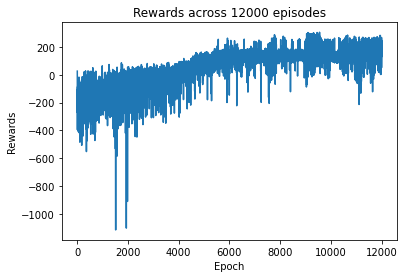

In [ ]:
plot_rewards(scores, episode=False)

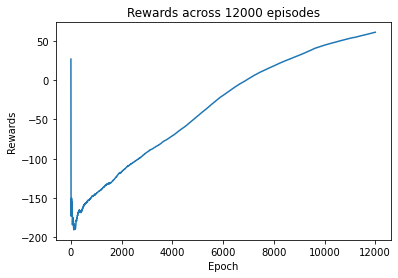

In [ ]:
avg_rew_calc = lambda x: [np.mean(x[:i+1]) for i in range(len(x))]
average_rewards = avg_rew_calc(scores)

plot_rewards(average_rewards, episode=False)

In [ ]:
frames, rewards = render_policy_net(actor_critic)
plot_animation(frames)

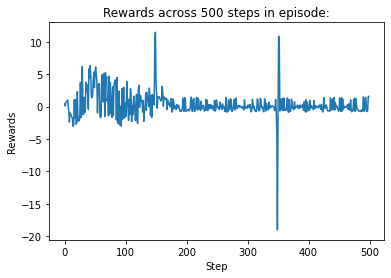

In [ ]:
plot_rewards(rewards)